# Import library

In [1]:
import torch
import torchvision
import cv2

print("PyTorch:", torch.__version__)
print("TorchVision:", torchvision.__version__)
print("OpenCV:", cv2.__version__)
print("GPU available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")


PyTorch: 2.5.1+cu121
TorchVision: 0.20.1+cu121
OpenCV: 4.12.0
GPU available: True
GPU name: NVIDIA GeForce RTX 3060 Laptop GPU


In [2]:
from datasets import load_dataset
from huggingface_hub import login
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
from huggingface_hub import hf_hub_download
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from sklearn.metrics import confusion_matrix
from torchinfo import summary
from torch.utils.data import Subset
import torch.nn as nn
import numpy as np
import torch
from torchvision import models
import torchvision.transforms as T
import cv2
from sklearn.metrics import average_precision_score
import os



# Data preprocessing

In [ ]:
login('token')

splits = {'train': 'dataset/multi_abnormality_labels/train_predicted_labels.csv', 'validation': 'dataset/multi_abnormality_labels/valid_predicted_labels.csv'}
df_train = pd.read_csv("hf://datasets/ibrahimhamamci/CT-RATE/" + splits["train"])
df_val = pd.read_csv("hf://datasets/ibrahimhamamci/CT-RATE/" + splits["validation"])


In [4]:
df_train

,VolumeName,Medical material,Arterial wall calcification,Cardiomegaly,Pericardial effusion,Coronary artery wall calcification,Hiatal hernia,Lymphadenopathy,Emphysema,Atelectasis,Lung nodule,Lung opacity,Pulmonary fibrotic sequela,Pleural effusion,Mosaic attenuation pattern,Peribronchial thickening,Consolidation,Bronchiectasis,Interlobular septal thickening
0,train_1_a_1.nii.gz,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0
1,train_1_a_2.nii.gz,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0
2,train_2_a_1.nii.gz,0,1,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0
3,train_2_a_2.nii.gz,0,1,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0
4,train_3_a_1.nii.gz,0,1,1,0,1,0,1,0,0,1,1,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47144,train_19998_a_2.nii.gz,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0
47145,train_19999_a_1.nii.gz,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
47146,train_19999_a_2.nii.gz,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
47147,train_20000_a_1.nii.gz,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0


In [5]:
print(df_train.drop('VolumeName', axis=1).mean())

Medical material                      0.123396
Arterial wall calcification           0.283718
Cardiomegaly                          0.112579
Pericardial effusion                  0.072366
Coronary artery wall calcification    0.255043
Hiatal hernia                         0.143184
Lymphadenopathy                       0.259200
Emphysema                             0.193472
Atelectasis                           0.260090
Lung nodule                           0.453498
Lung opacity                          0.369467
Pulmonary fibrotic sequela            0.267005
Pleural effusion                      0.120999
Mosaic attenuation pattern            0.077160
Peribronchial thickening              0.105474
Consolidation                         0.176441
Bronchiectasis                        0.100363
Interlobular septal thickening        0.079429
dtype: float64


In [6]:
df_val

,VolumeName,Medical material,Arterial wall calcification,Cardiomegaly,Pericardial effusion,Coronary artery wall calcification,Hiatal hernia,Lymphadenopathy,Emphysema,Atelectasis,Lung nodule,Lung opacity,Pulmonary fibrotic sequela,Pleural effusion,Mosaic attenuation pattern,Peribronchial thickening,Consolidation,Bronchiectasis,Interlobular septal thickening
0,valid_1_a_1.nii.gz,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,valid_1_a_2.nii.gz,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,valid_2_a_1.nii.gz,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0
3,valid_2_a_2.nii.gz,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0
4,valid_3_a_1.nii.gz,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3034,valid_1302_a_2.nii.gz,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0
3035,valid_1303_a_1.nii.gz,0,1,0,0,1,0,1,1,0,1,0,1,0,0,1,0,1,0
3036,valid_1303_a_2.nii.gz,0,1,0,0,1,0,1,1,0,1,0,1,0,0,1,0,1,0
3037,valid_1304_a_1.nii.gz,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
def preprocess_ct_psnr(img_tensor, denoise_h=1):
    img = img_tensor.squeeze().numpy()

    # Enhacing image dengan Gamma
    gamma=1.2
    out = np.power(img, gamma)

    # Enhancing image dengan clahe
    out = (out * 255).clip(0,255).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    out = clahe.apply(out)

    # Denoising dengan fastN1Means
    img_denoised = cv2.fastNlMeansDenoising(
        out, None, h=denoise_h,
        templateWindowSize=7, searchWindowSize=21
    )

    out = img_denoised.astype(np.float32) / 255.0

    return torch.from_numpy(out).unsqueeze(0)


In [ ]:
class CTRateDataset(Dataset):
    def __init__(self, csv_path, repo_id="ibrahimhamamci/CT-RATE", split="train", transform=None):
        self.df = pd.read_csv(csv_path)
        self.repo_id = repo_id
        self.split = split
        self.transform = transform

        self.label_columns = [
            "Medical material",
            "Arterial wall calcification",
            "Cardiomegaly",
            "Pericardial effusion",
            "Coronary artery wall calcification",
            "Hiatal hernia",
            "Lymphadenopathy",
            "Emphysema",
            "Atelectasis",
            "Lung nodule",
            "Lung opacity",
            "Pulmonary fibrotic sequela",
            "Pleural effusion",
            "Mosaic attenuation pattern",
            "Peribronchial thickening",
            "Consolidation",
            "Bronchiectasis",
            "Interlobular septal thickening"
        ]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        volume_name = row["VolumeName"]
        
        prefix = "dataset/train_fixed" if self.split == "train" else "dataset/valid_fixed"

        folder_lvl1 = f"{volume_name.split('_')[0]}_{volume_name.split('_')[1]}"   
        folder_lvl2 = "_".join(volume_name.split('_')[:3])                       

        file_path = hf_hub_download(
            repo_id=self.repo_id,
            filename=f"{prefix}/{folder_lvl1}/{folder_lvl2}/{volume_name}",
            repo_type="dataset"  
        )
        img = nib.load(file_path).get_fdata()
        
        mid_slice = img[:, :, img.shape[2] // 2]

        mid_slice = (mid_slice - np.min(mid_slice)) / (np.max(mid_slice) - np.min(mid_slice) + 1e-5)

        img_tensor = torch.tensor(mid_slice, dtype=torch.float32).unsqueeze(0)  # (1,H,W)
        img_tensor = F.interpolate(img_tensor.unsqueeze(0), size=(255,255), mode='bilinear', align_corners=False).squeeze(0)

        if self.transform:
            img_tensor = self.transform(img_tensor)

        # active_labels = [col for col in self.label_columns if row[col] == 1]
        labels = torch.tensor(row[self.label_columns].values.astype(np.float32))
        return img_tensor, labels


In [9]:
def collate_fn(batch):
    imgs, labels = zip(*batch)
    imgs = torch.stack(imgs, dim=0)
    labels = torch.stack(labels, dim=0)   # jadi tensor
    return imgs, labels

In [10]:
train_csv = "hf://datasets/ibrahimhamamci/CT-RATE/" + splits["train"]
val_csv   = "hf://datasets/ibrahimhamamci/CT-RATE/" + splits["validation"]

train_dataset = CTRateDataset(csv_path=train_csv, split="train", transform=lambda x: preprocess_ct_psnr(x))
val_dataset   = CTRateDataset(csv_path=val_csv, split="validation",transform=lambda x: preprocess_ct_psnr(x))

np.random.seed(42)
indices = np.random.choice(len(train_dataset), 1200,replace=False)
val_indi = np.random.choice(len(val_dataset), 300,replace=False)
train_subset = Subset(train_dataset, indices)
val_subset = Subset(val_dataset, val_indi)

train_loader = DataLoader(train_subset, batch_size=32, collate_fn=collate_fn, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, collate_fn=collate_fn ,shuffle=False)

In [14]:
ver_train = CTRateDataset(csv_path=train_csv, split="train",transform=lambda x: preprocess_ct_psnr(x))
ver_val = CTRateDataset(csv_path=val_csv, split="validation",transform=lambda x: preprocess_ct_psnr(x))
ver_train_loader = DataLoader(ver_train, batch_size=32,  collate_fn=collate_fn)
ver_val_loader = DataLoader(ver_val, batch_size=32,  collate_fn=collate_fn)

In [12]:
def show_ct_slice(img_tensor, labels_tensor, label_columns, figsize=(6,6)):
    # convert image ke numpy
    img = img_tensor.squeeze(0).cpu().numpy()  # (H,W)

    plt.figure(figsize=figsize)
    plt.imshow(img, cmap="gray")
    plt.axis("off")

    # ambil index dari label aktif (==1)
    labels_np = labels_tensor.cpu().numpy()
    active_idx = (labels_np == 1).nonzero()[0]   # index anomali
    active_labels = [label_columns[j] for j in active_idx]

    # tampilkan judul
    if active_labels:
        plt.title(" | ".join(active_labels), fontsize=8, color="red")
    else:
        plt.title("Normal", fontsize=8, color="green")

    plt.show()


Lihat image

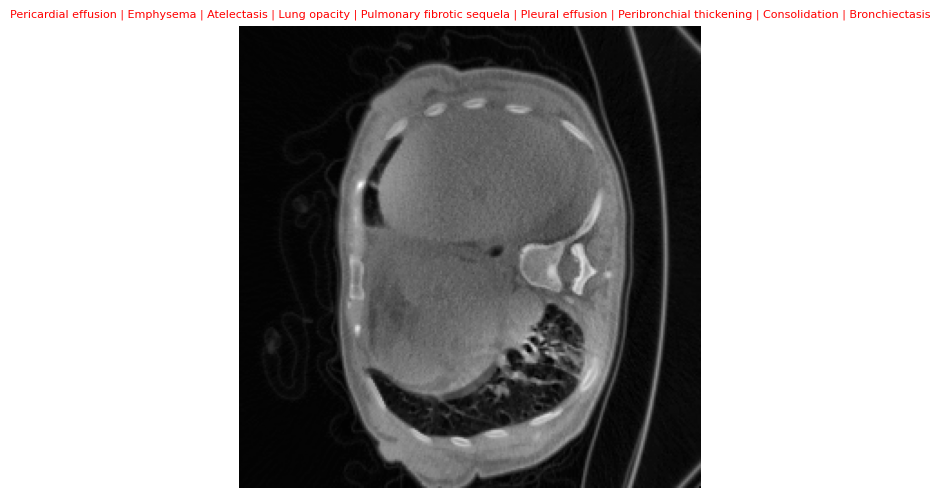

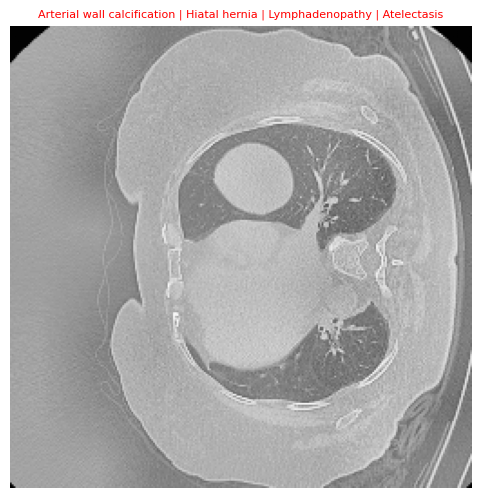

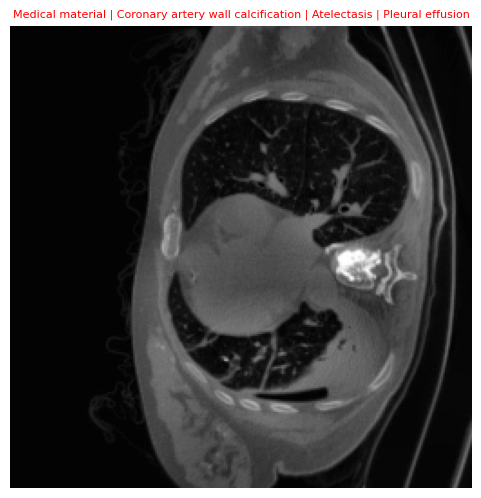

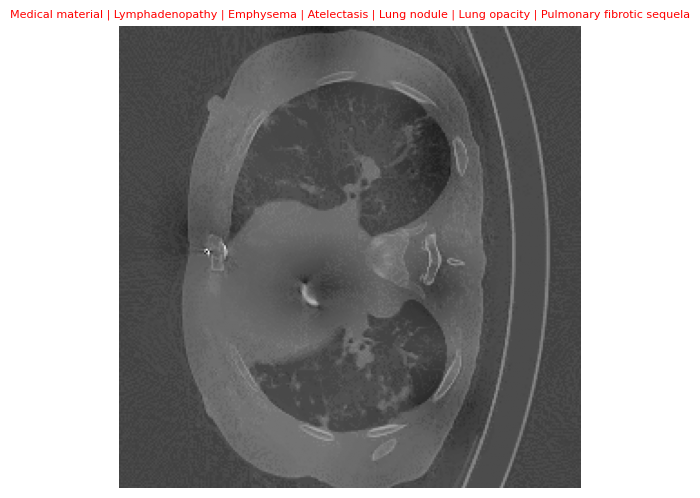

In [13]:
for imgs, labels in train_loader:
    for i in range(4):
        show_ct_slice(imgs[i], labels[i], train_dataset.label_columns)
    break  # cuma tampilkan batch pertama

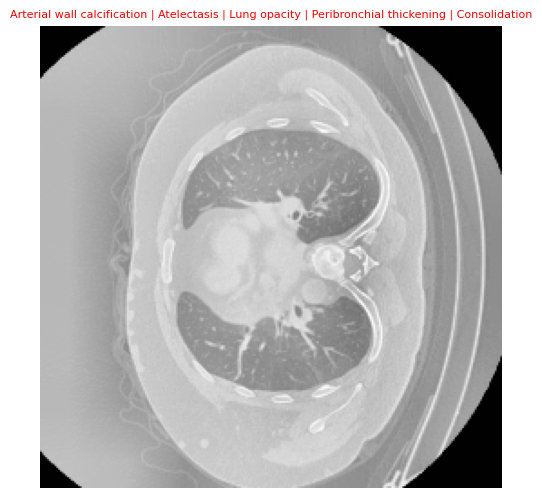

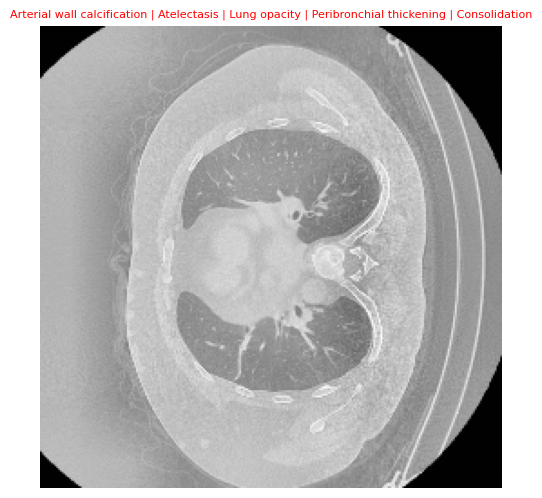

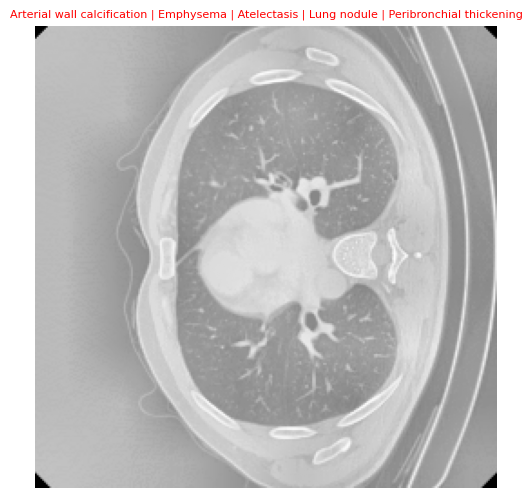

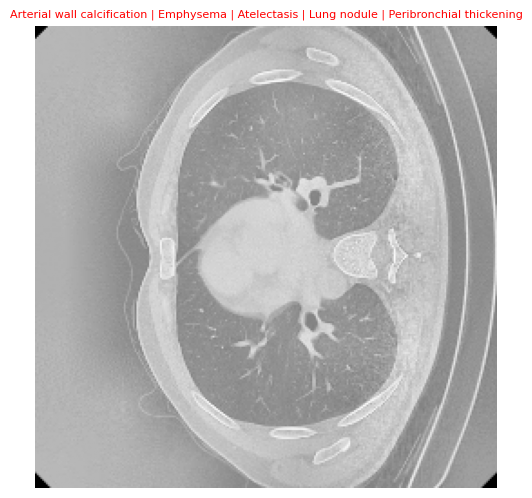

In [15]:
for imgs, labels in ver_train_loader:
    for i in range(4):
        show_ct_slice(imgs[i], labels[i], ver_train_loader.dataset.label_columns)
    break  # cuma tampilkan batch pertama
        

Verifikasi 20 data pertama

In [16]:
def calculate_metrics(img1, img2):
    """
    img1, img2: numpy array (float32) dengan nilai 0-1
    """
    # pastikan bentuk sama
    assert img1.shape == img2.shape, "Ukuran gambar tidak sama!"

    # MSE
    mse = np.mean((img1 - img2) ** 2)

    # RMSE
    rmse = np.sqrt(mse)

    # PSNR (pakai skimage, data_range=1 karena 0-1)
    psnr_val = peak_signal_noise_ratio(img1, img2, data_range=1.0)

    # SSIM
    ssim_val = structural_similarity(img1, img2, data_range=1.0)

    return mse, rmse, psnr_val, ssim_val


In [20]:
results = []

for i, ((proc_img, _), (orig_img, _)) in enumerate(zip(train_loader, ver_train_loader)):
    for b in range(proc_img.size(0)):
        img1 = orig_img[b, 0].numpy().astype(np.float32)
        img2 = proc_img[b, 0].numpy().astype(np.float32)

        mse, rmse, psnr_val, ssim_val = calculate_metrics(img1, img2)
        results.append({
            "Image": len(results) + 1,
            "PSNR": round(psnr_val, 2),
            "SSIM": round(ssim_val, 4),
            "MSE": round(mse, 2),
            "RMSE": round(rmse, 2)
        })

        if len(results) >= 20:  # ambil hanya 20 image pertama
            break
    if len(results) >= 20:
        break

# Buat DataFrame
df = pd.DataFrame(results)
df


,Image,PSNR,SSIM,MSE,RMSE
0,1,6.16,0.0892,0.24,0.49
1,2,6.10,0.0753,0.25,0.50
2,3,5.30,0.0746,0.30,0.54
3,4,5.09,0.1289,0.31,0.56
4,5,7.40,0.1552,0.18,0.43
5,6,5.89,0.0964,0.26,0.51
6,7,7.07,0.0705,0.20,0.44
7,8,5.31,0.0555,0.29,0.54
8,9,15.79,0.2369,0.03,0.16
9,10,10.93,0.0494,0.08,0.28


# Multi Classification Model Development

## CTTXENT MODEL

In [32]:

class ConvTokenizer(nn.Module):
    """Convolutional tokenizer: converts (B,C,H,W) -> (B, N, E) tokens"""
    def __init__(self, in_chans=1, embed_dim=256):
        super().__init__()
        # two conv stages to reduce spatial size and increase channels
        self.conv1 = nn.Conv2d(in_chans, embed_dim//2, kernel_size=7, stride=4, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(embed_dim//2)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(embed_dim//2, embed_dim, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(embed_dim)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        # x: (B, C, H, W)
        x = F.gelu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = F.gelu(self.bn2(self.conv2(x)))  # -> (B, E, H', W')
        x = self.pool2(x)
        B, E, H2, W2 = x.shape
        tokens = x.flatten(2).transpose(1, 2)  # -> (B, N, E) where N=H'*W'
        return tokens, (H2, W2)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim=None, dropout=0.1):
        super().__init__()
        hidden_dim = hidden_dim or dim * 4
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class DropPath(nn.Module):
    """Stochastic Depth (per sample)"""
    def __init__(self, drop_prob=0.1):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if self.drop_prob == 0. or not self.training:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor.floor_()
        return x.div(keep_prob) * random_tensor
    
class TransformerEncoderBlock(nn.Module):
    def __init__(self, dim, num_heads=4, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, dropout=dropout, batch_first=True)
        self.drop_path = DropPath(drop_prob=dropout)  # placeholder for stochastic depth if needed
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = FeedForward(dim, int(dim * mlp_ratio), dropout=dropout)

    def forward(self, x):
        # x: (B, N, E)
        # MultiheadAttention with batch_first=True expects (B, N, E)
        x_res = x
        x = self.norm1(x)
        attn_out, _ = self.attn(x, x, x, need_weights=False)
        x = x_res + self.drop_path(attn_out)
        x_res = x
        x = self.norm2(x)
        x = x_res + self.drop_path(self.mlp(x))
        return x


class SequencePooling(nn.Module):
    """Simple sequence pooling: average pooling across tokens (N->1)"""
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # x: (B, N, E) -> pooled (B, E)
        return x.mean(dim=1)
    
class DataAugmentation(nn.Module):
    def __init__(self):
        super().__init__()
        self.transforms = T.Compose([
            T.RandomResizedCrop(255, scale=(0.8, 1.0)),
            T.RandomHorizontalFlip(),
            T.RandomRotation(10),
        ])
    
    def forward(self, x):
        # jika input tensor (B,C,H,W), gunakan torchvision v2 functional
        return torch.stack([self.transforms(img) for img in x])


class CTXNet(nn.Module):
    def __init__(self,
                 in_chans=1,
                 num_classes=18,
                 embed_dim=256,
                 depth=6,
                 num_heads=16,
                 mlp_ratio=6.0,
                 dropout=0.1):
        super().__init__()
        self.augment = DataAugmentation()
        self.tokenizer = ConvTokenizer(in_chans=in_chans, embed_dim=embed_dim)

        # optional learnable position embedding (small)
        self.pos_embed = None  # we'll init lazily once we know token count

        # transformer blocks
        self.blocks = nn.ModuleList([
            TransformerEncoderBlock(dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, dropout=dropout)
            for _ in range(depth)
        ])

        self.norm = nn.LayerNorm(embed_dim)
        self.pool = SequencePooling()

        # classifier head
        self.head = nn.Sequential(
            nn.Linear(embed_dim, embed_dim // 2),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(embed_dim // 2, num_classes)
        )

    def forward(self, x):
        # x: (B, C, H, W)
        x = self.augment(x)
        B = x.shape[0]
        tokens, (Hn, Wn) = self.tokenizer(x)       # tokens: (B, N, E)
        N = tokens.shape[1]

        # create pos emb if needed
        if self.pos_embed is None or self.pos_embed.shape[1] != N:
            # small learnable pos emb
            self.pos_embed = nn.Parameter(torch.zeros(1, N, tokens.shape[2]).to(tokens.device))
            nn.init.trunc_normal_(self.pos_embed, std=0.02)

        tokens = tokens + self.pos_embed

        # transformer blocks (B,N,E)
        for blk in self.blocks:
            tokens = blk(tokens)

        tokens = self.norm(tokens)
        pooled = self.pool(tokens)   # (B, E)
        logits = self.head(pooled)   # (B, num_classes)
        return logits
        


CTTXNet = CTXNet(in_chans=1, num_classes=18, embed_dim=256, depth=6, num_heads=16).to('cuda')
summary(CTTXNet)

Layer (type:depth-idx)                                       Param #
CTXNet                                                       --
├─DataAugmentation: 1-1                                      --
├─ConvTokenizer: 1-2                                         --
│    └─Conv2d: 2-1                                           6,272
│    └─BatchNorm2d: 2-2                                      256
│    └─MaxPool2d: 2-3                                        --
│    └─Conv2d: 2-4                                           294,912
│    └─BatchNorm2d: 2-5                                      512
│    └─MaxPool2d: 2-6                                        --
├─ModuleList: 1-3                                            --
│    └─TransformerEncoderBlock: 2-7                          --
│    │    └─LayerNorm: 3-1                                   512
│    │    └─MultiheadAttention: 3-2                          263,168
│    │    └─DropPath: 3-3                                    --
│    │    └─LayerNo

## EfficientNetB0CNN

In [12]:
class CTAbnormalityClassifier2D(nn.Module):
    def __init__(self, num_classes=18, pretrained=True, dropout=0.2):
        super(CTAbnormalityClassifier2D, self).__init__()

        self.backbone = models.efficientnet_b0(pretrained=pretrained)

        in_features = self.backbone.classifier[1].in_features

        self.backbone.classifier = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Dropout(dropout),
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        out = self.backbone(x)
        return out
    
b0model = CTAbnormalityClassifier2D()
b0model.backbone.features[0][0] = nn.Conv2d(
    1, 32, kernel_size=3, stride=2, padding=1, bias=False
)
b0model = b0model.to('cuda')

d:\AnacondaPython\envs\torch_gpu_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\AnacondaPython\envs\torch_gpu_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Training

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  model.train()
  running_loss = 0
  correct = 0
  total_labels = 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    optimizer.zero_grad()
    pred = model(X)
    loss = loss_fn(pred, y)

    loss.backward()
    optimizer.step()
    
    running_loss += loss.item() * X.size(0)
    threshold = 0.5
    preds = torch.sigmoid(pred) > threshold
    correct += (preds == (y > 0.5)).sum().item()
    total_labels += y.numel() 

    if batch % 100 == 0:
      loss, current = loss.item(), (batch + 1) * len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
  
  epoch_loss = running_loss / size
  epoch_acc = correct / total_labels
  return epoch_loss, epoch_acc


In [ ]:
def test(dataloader, model, loss_fn, threshold=0.5):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, total_correct, total_labels = 0, 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            
            test_loss += loss_fn(pred, y).item()
            
            # apply sigmoid + threshold
            preds = torch.sigmoid(pred) > threshold
            
            # hitung berapa label yg benar
            total_correct += (preds == (y > 0.5)).sum().item()
            total_labels += y.numel()
    
    test_loss /= num_batches
    acc = total_correct / total_labels
    print(f"Test Error: \n Accuracy: {(100*acc):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, acc

In [25]:
y_train_list = []

with torch.no_grad():
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to('cuda'), y_train.to('cuda')

        y_train_list.append(y_train.cpu().numpy())

y_true = np.vstack(y_train_list)


n_pos = np.sum(y_true, axis=0)
n_neg = y_true.shape[0] - n_pos
pos_weight = n_neg / (n_pos + 1e-8)

pos_weight = torch.tensor(pos_weight, dtype=torch.float32, device='cuda')

In [46]:
history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = torch.optim.Adam(b0model.parameters(), lr=1e-5)
epochs = 5
for e in range(epochs):
  print(f"Epoch {e+1}\n-------------------------------")
  train_loss, train_acc = train(train_loader,b0model, loss_fn, optimizer)
  test_loss, test_acc = test(val_loader,b0model, loss_fn)
  history['train_loss'].append(train_loss)
  history['train_acc'].append(train_acc)
  history['test_loss'].append(test_loss)
  history['test_acc'].append(test_acc)
print("Done!")

Epoch 1
-------------------------------
loss: 1.086998  [   32/ 1200]
Test Error: 
 Accuracy: 57.7%, Avg loss: 1.135436 

Epoch 2
-------------------------------
loss: 1.059148  [   32/ 1200]
Test Error: 
 Accuracy: 57.6%, Avg loss: 1.132668 

Epoch 3
-------------------------------
loss: 1.070529  [   32/ 1200]
Test Error: 
 Accuracy: 57.4%, Avg loss: 1.129786 

Epoch 4
-------------------------------
loss: 1.151373  [   32/ 1200]
Test Error: 
 Accuracy: 57.8%, Avg loss: 1.128058 

Epoch 5
-------------------------------
loss: 1.055996  [   32/ 1200]
Test Error: 
 Accuracy: 57.2%, Avg loss: 1.126085 

Done!


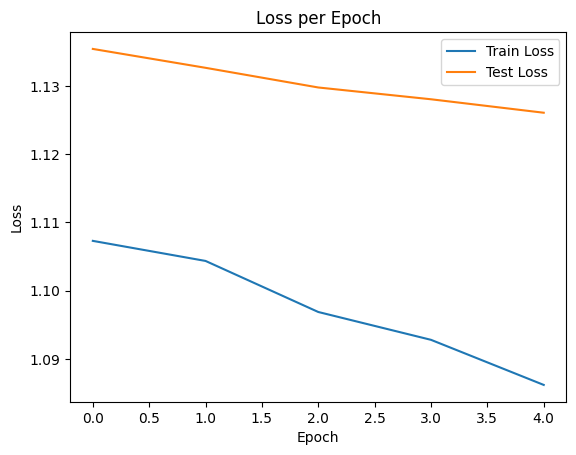

In [47]:
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['test_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.show()

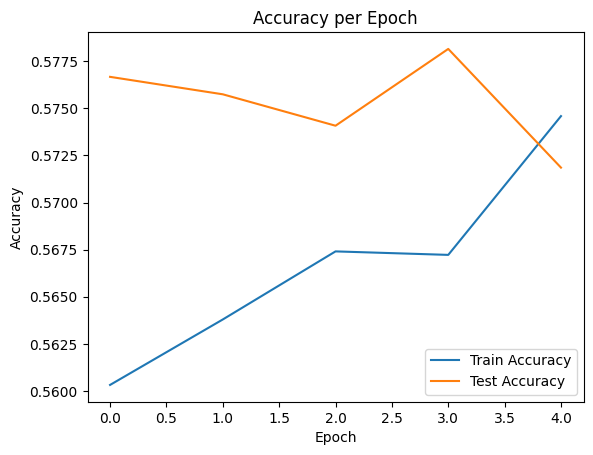

In [48]:
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['test_acc'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()
plt.show()

# Save model

In [13]:
# # torch.save(b0model, 'modelb0(1500data).pth')
saved_model = CTAbnormalityClassifier2D()
saved_model.backbone.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
saved_model = torch.load('modelb0(1500data).pth')
saved_model = saved_model.to('cuda')

C:\Users\arsyad\AppData\Local\Temp\ipykernel_6972\3056525469.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_model = torch.load('modelb0(1500data).pth')


In [ ]:
# # torch.save(CTTXNet.state_dict(), "CTTXNetmodel_clip_limit3.0_1500dataShuffle(Modified).pth")
# saved_model =CTXNet(in_chans=1, num_classes=18, embed_dim=256, depth=6, num_heads=16).to('cuda')
# state_dict = torch.load("CTTXNetmodel_clip_limit3.0_1500dataShuffle(Modified).pth")
# saved_model.load_state_dict(state_dict, strict=False)

C:\Users\arsyad\AppData\Local\Temp\ipykernel_18220\778840580.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("CTTXNetmodel_clip_limit3.0_1500data

_IncompatibleKeys(missing_keys=[], unexpected_keys=['pos_embed'])

# Evaluasi metric

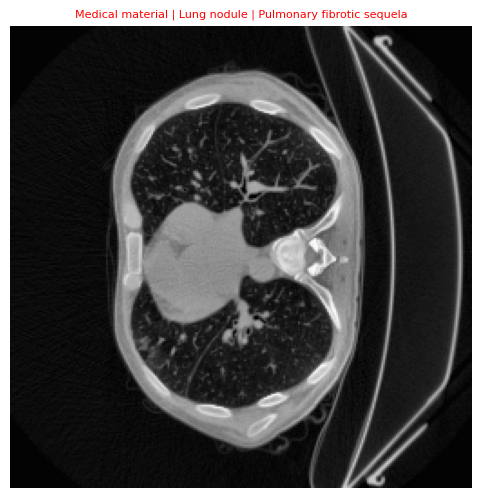

Predicted: ['Hiatal hernia', 'Atelectasis', 'Lung nodule', 'Lung opacity', 'Pleural effusion', 'Peribronchial thickening', 'Bronchiectasis'], Actual: ['Lung nodule']


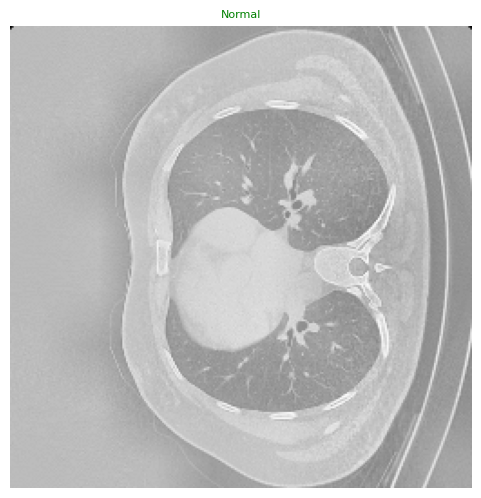

Predicted: ['Lymphadenopathy', 'Atelectasis', 'Lung nodule', 'Lung opacity', 'Bronchiectasis'], Actual: ['Lung nodule']


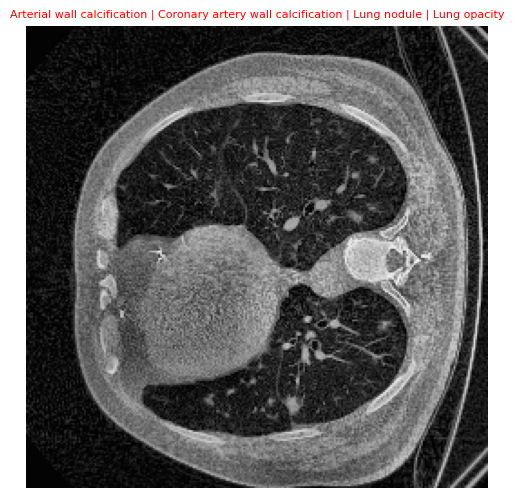

Predicted: ['Medical material', 'Emphysema', 'Atelectasis', 'Lung opacity', 'Pleural effusion', 'Bronchiectasis'], Actual: ['Hiatal hernia', 'Lung nodule', 'Pulmonary fibrotic sequela', 'Peribronchial thickening']


In [ ]:
for imgs, labels in val_loader:
    for i in range(3):
        show_ct_slice(imgs[i], labels[i], val_dataset.label_columns)
        x, y = val_dataset[i]
        x = x.unsqueeze(0).to('cuda')  # tambah batch dim
        with torch.no_grad():
            pred = saved_model(x)                # logits dari model
            probs = torch.sigmoid(pred)          # ubah ke probabilitas 0-1
            pred_labels = (probs > 0.5).int()    # threshold 0.5 → 0/1

        #mapping ke nama label
        pred_label_names = [val_dataset.label_columns[j] for j in range(len(val_dataset.label_columns)) if pred_labels[0, j] == 1]
        actual_label_names = [val_dataset.label_columns[j] for j in range(len(val_dataset.label_columns)) if y[j] == 1]

        print(f'Predicted: {pred_label_names}, Actual: {actual_label_names}')
    break  # cuma tampilkan batch pertama


In [15]:
def evaluate(y_true, y_pred, threshold=None):
    n_labels = y_true.shape[1]
    results = []
    for i in range(n_labels):
        thr = threshold[i] if threshold is not None else 0.5
        y_pred_binary = (y_pred[:, i] > thr).astype(int)
        TN, FP, FN, TP = confusion_matrix(y_true[:, i], y_pred_binary, labels=[0,1]).ravel()

        ACC = (TP + TN) / (TP + TN + FP + FN + 1e-8) # 1e-8 mencegah misal pembaginya 0
        PREC = TP / (TP + FP + 1e-8)
        RECC = TP / (TP + FN + 1e-8)
        SPEC = TN / (TN + FP + 1e-8)
        FDR = FP / (TP + FP + 1e-8)
        FPR = FP / (TN + FP + 1e-8)
        FNR = FN / (TP + FN + 1e-8)
        NPV = TN / (TN + FN + 1e-8)
        F1 = 2 * (PREC * RECC) / (PREC + RECC + 1e-8)
        MCC = ((TP * TN) - (FP * FN)) / np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN) + 1e-8)

        results.append({
            "ACC":ACC,
            "Precision":PREC,
            'Recall': RECC,
            'Specificity': SPEC,
            'F1':F1,
            'FPR':FPR,
            'FNR':FNR,
            'FDR':FDR,
            'NPV':NPV,
            'MCC':MCC
        })
    
    df_eval = pd.DataFrame(results)
    return df_eval

        

Evaluasi training

In [ ]:
from sklearn.metrics import matthews_corrcoef

saved_model.eval()
y_train_true_list = []
y_train_pred_list = []

with torch.no_grad():
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to('cuda'), y_train.to('cuda')
        preds = saved_model(X_train)

        y_train_true_list.append(y_train.cpu().numpy())
        y_train_pred_list.append(torch.sigmoid(preds).cpu().numpy())  # sigmoid biar jadi probabilitas

y_true = np.vstack(y_train_true_list)
y_pred = np.vstack(y_train_pred_list)


thresholds = []
for i in range(y_true.shape[1]):
    best_thr, best_mcc = 0.5, 0
    for t in np.arange(0.1, 0.9, 0.05):
        mcc = matthews_corrcoef(y_true[:, i], (y_pred[:, i] > t).astype(int))
        if mcc > best_mcc:
            best_mcc, best_thr = mcc, t
    thresholds.append(best_thr)

df_metrics_train = evaluate(y_true, y_pred, threshold=thresholds)
df_metrics_train

In [ ]:
mAP_train = average_precision_score(y_true, y_pred, average="macro")  
print(f"mAP (Train): {mAP_train:.4f}")

mAP (Train): 0.2741


Evaluasi validasi

In [ ]:
saved_model.eval()
y_val_true_list = []
y_val_pred_list = []

with torch.no_grad():
    for X_val, y_val in val_loader:
        X_val, y_val = X_val.to('cuda'), y_val.to('cuda')
        preds = saved_model(X_val)

        y_val_true_list.append(y_val.cpu().numpy())
        y_val_pred_list.append(torch.sigmoid(preds).cpu().numpy())  # sigmoid biar jadi probabilitas

y_true = np.vstack(y_val_true_list)
y_pred = np.vstack(y_val_pred_list)

thresholds = []
for i in range(y_true.shape[1]):
    best_thr, best_mcc = 0.5, 0
    for t in np.arange(0.1, 0.9, 0.05):
        mcc = matthews_corrcoef(y_true[:, i], (y_pred[:, i] > t).astype(int))
        if mcc > best_mcc:
            best_mcc, best_thr = mcc, t
    thresholds.append(best_thr)

df_metrics_val = evaluate(y_true, y_pred, threshold=thresholds)
df_metrics_val

,ACC,Precision,Recall,Specificity,F1,FPR,FNR,FDR,NPV,MCC
0,0.543333,0.142857,0.656250,0.529851,0.234637,0.470149,0.343750,0.857143,0.928105,0.114917
1,0.610000,0.408000,0.542553,0.640777,0.465753,0.359223,0.457447,0.592000,0.754286,0.172487
2,0.833333,0.409091,0.428571,0.899225,0.418605,0.100775,0.571429,0.590909,0.906250,0.321508
3,0.746667,0.175676,0.464286,0.775735,0.254902,0.224265,0.535714,0.824324,0.933628,0.161973
4,0.533333,0.339080,0.702381,0.467593,0.457364,0.532407,0.297619,0.660920,0.801587,0.154628
5,0.403333,0.132653,0.742857,0.358491,0.225108,0.641509,0.257143,0.867347,0.913462,0.068364
6,0.583333,0.358621,0.619048,0.569444,0.454148,0.430556,0.380952,0.641379,0.793548,0.169360
7,0.716667,0.265625,0.309091,0.808163,0.285714,0.191837,0.690909,0.734375,0.838983,0.110751
8,0.660000,0.367816,0.405063,0.751131,0.385542,0.248869,0.594937,0.632184,0.779343,0.151609
9,0.490000,0.437908,0.500000,0.481928,0.466899,0.518072,0.500000,0.562092,0.544218,-0.017973


In [ ]:
mAP_val = average_precision_score(y_true, y_pred, average="macro")
print(f"mAP (Validation): {mAP_val:.4f}")

mAP (Validation): 0.2820


# GRAD CAM BASED VISUALIZATION

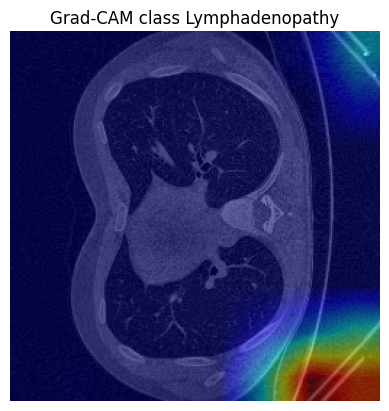

In [19]:
saved_model.eval()
# untuk model CTXNET
# target_layer = saved_model.tokenizer.conv2 # ngambil layer convutional terakhir sebelum transformer biar bisa melihat area gambar yang kontribusi pas prediksi
# untuk model efficientb0
target_layer = saved_model.backbone.features[-1] # ngambil layer backbone terakhir bair bisa liat area mana yg paling berkontribusi pas prediksi

features = []
def forward_hook(module, input, output):
    output.retain_grad()
    features.append(output)

hook_handle = target_layer.register_forward_hook(forward_hook)

# ngitung grad cam
ct_slice, y = val_dataset[0]
x= ct_slice.unsqueeze(0).to('cuda')
pred = saved_model(x)

target_class = 6
saved_model.zero_grad()
pred[0, target_class].backward(retain_graph=True)

feature_map = features[0]
gradients = feature_map.grad

weights = gradients.mean(dim=(2, 3), keepdim=True)
cam = (weights * feature_map).sum(dim=1)
cam = F.relu(cam)
cam = cam[0].cpu().detach().numpy()

# resize hearmap ke ukuran input CT
H, W = ct_slice.shape[1], ct_slice.shape[2]
cam_resized = cv2.resize(cam, (W, H))
cam_resized = (cam_resized - cam_resized.min()) / (cam_resized.max()- cam_resized.min())


# visualisasi
target_label_name = val_dataset.label_columns[target_class]
ct_vis = ct_slice.squeeze().cpu().numpy()
plt.imshow(ct_vis, cmap='gray')
plt.imshow(cam_resized , cmap='jet', alpha=0.5)
plt.title(f'Grad-CAM class {target_label_name}')
plt.axis('off')
plt.show()
